In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
jobs = pd.read_csv("fake_job_postings.csv")
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Number of Rows and Columns

In [3]:
rows = jobs.shape[0]
cols = jobs.shape[1]

print(f"The above Adult dataset has \033[1m {rows} rows\033[0m and \033[1m{cols} columns \033[0m.")

The above Adult dataset has  17880 rows and 18 columns .


### Null Values in Dataset

In [4]:
[[features,jobs[features].isnull().sum()] for features in jobs.columns if jobs[features].isnull().sum()>0]

[['location', 346],
 ['department', 11547],
 ['salary_range', 15012],
 ['company_profile', 3308],
 ['description', 1],
 ['requirements', 2695],
 ['benefits', 7210],
 ['employment_type', 3471],
 ['required_experience', 7050],
 ['required_education', 8105],
 ['industry', 4903],
 ['function', 6455]]

### Heatmap of Missing Values

<AxesSubplot:>

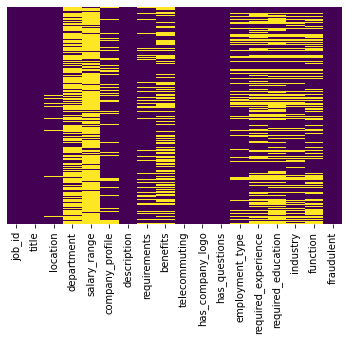

In [5]:
sns.heatmap(jobs.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Droping unnecessary Columns

In [6]:
columns = ['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']

for col in columns:
    del jobs[col]
    
jobs.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Filling NaN values with Blank space

In [7]:
jobs.fillna('', inplace=True)

### Comparing Number of Fraudlent and Non-Fraudlent Job Posting

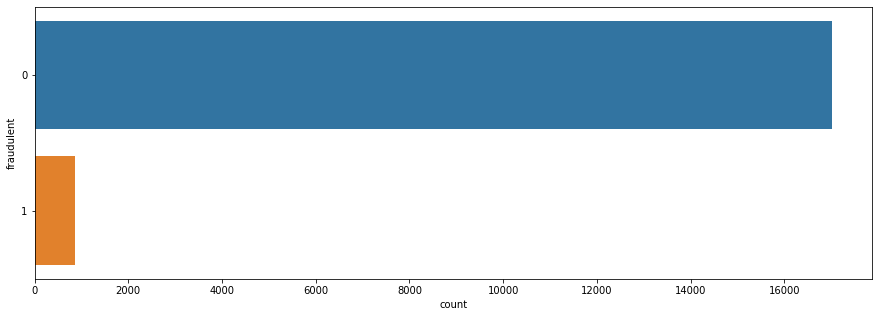

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent', data=jobs)
plt.show()

### Number of Fraudlent and Non-Fraudlent Jobs

In [9]:
not_fraudulent = jobs.groupby('fraudulent')['fraudulent'].count()[0]
fraudulent = jobs.groupby('fraudulent')['fraudulent'].count()[1]

print(f"\033[1m {not_fraudulent}\033[0m jobs are \033[1mNOT Fraudulent\033[0m and \033[1m{fraudulent}\033[0m jobs are \033[1mFraudulent\033[0m.")

 17014 jobs are NOT Fraudulent and 866 jobs are Fraudulent.


### Experiencewise Count

In [10]:
exp = dict(jobs.required_experience.value_counts())
del exp['']

exp_df = pd.DataFrame.from_dict(exp, orient ='index') 
exp_df.T

,Mid-Senior level,Entry level,Associate,Not Applicable,Director,Internship,Executive
0,3809,2697,2297,1116,389,381,141


### Bar Plot

#### Experience Vs No. of Jobs

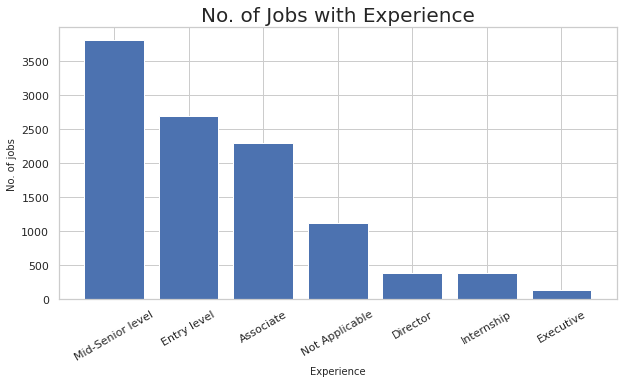

In [11]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
plt.bar(exp.keys(),exp.values())
plt.title('No. of Jobs with Experience', size=20)
plt.xlabel('Experience',size=10)
plt.ylabel('No. of jobs',size=10)
plt.xticks(rotation=30)
plt.show()

### Countrywise Job Count

In [12]:
# First Spliting location Column to extract Country Code
def split(location):
    l = location.split(',')
    return l[0]

jobs['country'] = jobs.location.apply(split)

jobs.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [13]:
countr = dict(jobs.country.value_counts()[:14])
del countr['']
countr

countr_df = pd.DataFrame.from_dict(countr, orient ='index') 
countr_df.T

,US,GB,GR,CA,DE,NZ,IN,AU,PH,NL,BE,IE,SG
0,10656,2384,940,457,383,333,276,214,132,127,117,114,80


### Bar Plot

#### Top 14 Country Vs No. of Jobs

Text(0.5, 0, 'Countries')

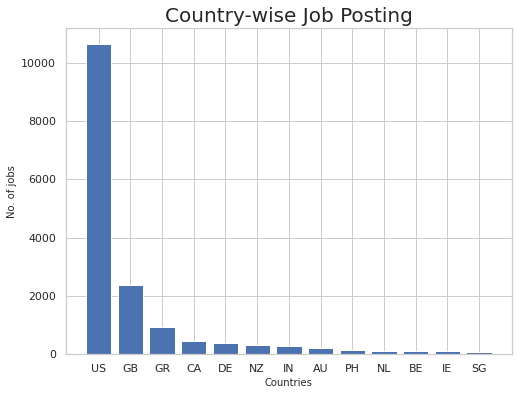

In [14]:
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(countr.keys(), countr.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

### Education Job Count

In [15]:
edu = dict(jobs.required_education.value_counts()[:7])
del edu['']
edu

edu_df = pd.DataFrame.from_dict(edu, orient ='index') 
edu_df.T

,Bachelor's Degree,High School or equivalent,Unspecified,Master's Degree,Associate Degree,Certification
0,5145,2080,1397,416,274,170


### Barplot

#### Education Vs No. of Jobs

Text(0.5, 0, 'Education')

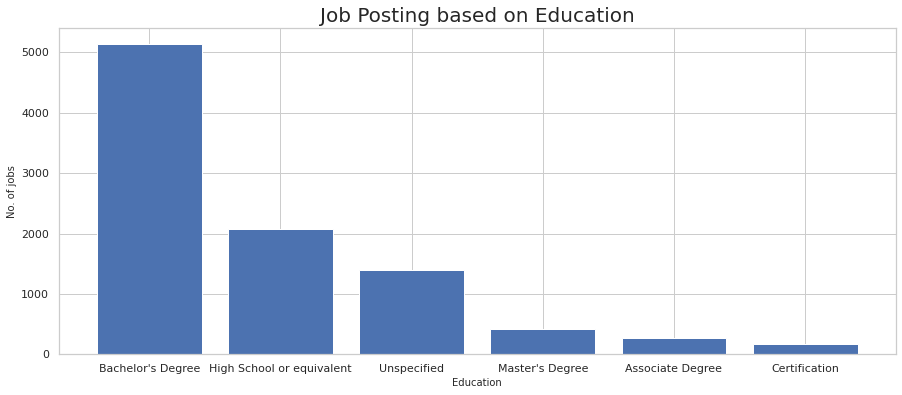

In [16]:
plt.figure(figsize=(15,6))
plt.title('Job Posting based on Education', size=20)
plt.bar(edu.keys(), edu.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Education', size=10)

### Top 10 Titles of Jobs Posted which were NOT fraudulent

In [17]:
print(jobs[jobs.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


### Top 10 Titles of Jobs Posted which were fraudulent

In [18]:
print(jobs[jobs.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [19]:
jobs.head(1)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US


In [20]:
def text_fraud_df(jobs):
    jobs.fillna('', inplace=True)
    jobs['text'] = jobs['title'] + ' ' + jobs['company_profile'] + ' '+ jobs['description'] + jobs['requirements'] + ' ' + jobs['benefits'] 

    for col in jobs.columns:
        if col not in ['text','fraudulent']:
            del jobs[col]
    
    return jobs

In [21]:
jobs = text_fraud_df(jobs)

In [22]:
_check = jobs.copy()
jobs.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [23]:
fake = pd.read_csv("/home/utkarsh/Documents/Machine Learning/UGB/ML/CE/fake_job_test_2.csv")
fake

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other
1,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other


In [24]:
fake = text_fraud_df(fake)

In [25]:
new = _check.append(fake, ignore_index = True)

### Creating a Cloud based on Fradulent Jobs and Non-Fraudelent Jobs

In [26]:
fraud_jobs_text = jobs[jobs.fraudulent == 1].text
real_jobs_text = jobs[jobs.fraudulent == 0].text

In [27]:
#!pip install spacy && python3 -m spacy download en

In [28]:
# Cleaning and preprocessing
# Create our list of punctuation marks
punctuation = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Create our tokenizer function
def spacy_tokenizer(sentencce):
    # Createing our taken object, which is used to create documents with linguistic annotations
    mytokens = parsar(sentence)
    
    # Lemmatizing each taken and converting each taken into lowercase
    mytokens = [word.lemma_lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    
    mytockens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_parmas):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()

In [29]:
def term_freq(temp_df):
    temp_df['text'] = temp_df['text'].apply(clean_text)

    cv = TfidfVectorizer(max_features = 100)
    x = cv.fit_transform(temp_df['text'])

    df = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())

    temp_df.drop(['text'], axis=1, inplace=True)

    return pd.concat([df, temp_df], axis=1)

In [30]:
main_df = term_freq(jobs)

/home/utkarsh/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
main_test = term_freq(new)

In [32]:
main_test.tail()[-2:].drop('fraudulent',axis=1)

,ability,about,all,also,amp,an,and,are,as,at,...,well,who,will,with,work,working,world,years,you,your
17880,0.167408,0.000000,0.112728,0.000000,0.186310,0.037926,0.714729,0.036069,0.210423,0.022291,...,0.000000,0.027734,0.0,0.120652,0.130284,0.074445,0.0,0.023745,0.060245,0.047493
17881,0.073675,0.019805,0.148833,0.020431,0.158131,0.037555,0.589778,0.059527,0.101025,0.014715,...,0.058097,0.018308,0.0,0.099559,0.122866,0.016381,0.0,0.047025,0.000000,0.047028


In [33]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12516, 100)
(5364, 100)
(12516,)
(5364,)


In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="gini")
model = rfc.fit(X_train, y_train)

In [35]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test, pred)
score

0.9703579418344519

In [36]:
print("Classification Report")
print(classification_report(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5100
           1       1.00      0.40      0.57       264

    accuracy                           0.97      5364
   macro avg       0.98      0.70      0.78      5364
weighted avg       0.97      0.97      0.96      5364



In [37]:
print("Confusion Matrix")
print(confusion_matrix(y_test, pred))

Confusion Matrix
[[5100    0]
 [ 159  105]]


KNN

SVM

Predict

In [38]:
rfc.predict(main_test.tail()[-2:].drop('fraudulent',axis=1))

array([1, 1])

In [39]:
rfc.predict(main_df[main_df['fraudulent'] == 1].head(2).drop('fraudulent',axis=1))

array([1, 1])

In [40]:
rfc.predict(main_df[main_df['fraudulent'] == 0].head(2).drop('fraudulent',axis=1))

array([0, 0])

In [41]:
main_df[main_df['fraudulent'] == 1].head(2)

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
98,0.167420,0.0,0.112732,0.0,0.186322,0.037926,0.714718,0.03607,0.210426,0.022291,...,0.027736,0.000000,0.120651,0.130286,0.074449,0.0,0.023746,0.060243,0.047495,1
144,0.155225,0.0,0.000000,0.0,0.000000,0.000000,0.248497,0.00000,0.000000,0.000000,...,0.000000,0.221243,0.167794,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1


In [42]:
main_test.tail()[-2:]

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
17880,0.167408,0.000000,0.112728,0.000000,0.186310,0.037926,0.714729,0.036069,0.210423,0.022291,...,0.027734,0.0,0.120652,0.130284,0.074445,0.0,0.023745,0.060245,0.047493,NaN
17881,0.073675,0.019805,0.148833,0.020431,0.158131,0.037555,0.589778,0.059527,0.101025,0.014715,...,0.018308,0.0,0.099559,0.122866,0.016381,0.0,0.047025,0.000000,0.047028,NaN
